In [42]:
# Import Data

In [43]:
import itertools
import os
# plt.style.use('ggplot')
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, Activation
# from keras.callbacks import EarlyStopping

filterwarnings('ignore')
# % matplotlib
# inline

In [44]:
# set data folder path
# DATA_FOLDER = 'D:\\NUS\\semester 2\\Course 3\\CA\\MAREA_dataset'
# DATA_FOLDER = '/Users/jiahao/Downloads/MAREA_dataset'
DATA_FOLDER = r'D:/NUS_TERM2_CA3/MAREA_dataset'
# DATA_FOLDER = 'C:/Users/david/Documents/CA3/MAREA_dataset-201/MAREA_dataset'
ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject Data_txt format')
PROCESSED_FOLDER = os.path.join(DATA_FOLDER, 'Processed_data')

# define activity timing labels
label_indoor = ['tread_flat_walk_start',
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end']

label_outdoor = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

# prepare timing index for different activities
df_indoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                             , names=label_indoor)

df_outdoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                              , names=label_outdoor)

df_indoor_time["subject"] = ["Sub" + str(i) for i in range(1, 12)]
df_outdoor_time["subject"] = ["Sub" + str(j) for j in range(12, 21)]

In [45]:
# set up activity column names
axis_list = ['accX', 'accY', 'accZ']
pos_list = ['LF', 'RF', 'Waist', 'Wrist']
sub_list = ['Sub' + str(i) for i in range(1, 21)]
column_names = [f"{y}_{x}" for x, y in itertools.product(pos_list, axis_list)]

# TODO: purposely exclude subject 4 first as missing data -- dont know how to deal with missing data for signal
sub_list.remove('Sub4')

In [46]:
column_names

['accX_LF',
 'accY_LF',
 'accZ_LF',
 'accX_RF',
 'accY_RF',
 'accZ_RF',
 'accX_Waist',
 'accY_Waist',
 'accZ_Waist',
 'accX_Wrist',
 'accY_Wrist',
 'accZ_Wrist']

In [47]:
# create master dataframe
const_master_df = pd.DataFrame()
for sub in sub_list:
    df_lf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    df_rf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    df_waist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    df_wrist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    df_sub = pd.concat([df_lf, df_rf, df_waist, df_wrist], axis=1)
    df_sub.columns = column_names

    df_sub = df_sub.copy()
    n = int(sub[3:])
    if n > 11:
        sub_row = df_outdoor_time[df_outdoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['outdoor_walk_end'], 'label'] = 'outdoor_walk'
        df_sub.loc[tmp['outdoor_walk_end']: tmp['outdoor_run_end'], 'label'] = 'outdoor_run'
    else:
        sub_row = df_indoor_time[df_indoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
        df_sub.loc[tmp['tread_flat_walk_end']: tmp['tread_flat_run_end'], 'label'] = 'tread_flat_run'
        df_sub.loc[tmp['tread_flat_run_end']: tmp['tread_slope_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['tread_slope_walk_start']: tmp['tread_slope_walk_end'], 'label'] = 'tread_slope_walk'
        df_sub.loc[tmp['tread_slope_walk_end']: tmp['indoor_flat_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['indoor_flat_walk_start']: tmp['indoor_flat_walk_end'], 'label'] = 'indoor_flat_walk'
        df_sub.loc[tmp['indoor_flat_walk_end']: tmp['indoor_flat_run_end'], 'label'] = 'indoor_flat_run'

    df_sub['subject'] = sub
    const_master_df = const_master_df.append(df_sub)
    # print(df.shape)

In [48]:
const_master_df.head(5)


accX_LF  accY_LF  accZ_LF  accX_RF  accY_RF  accZ_RF  accX_Waist  \
0   -2.196  -11.765   -1.569    4.078   -6.902    2.196      -0.157   
1   -2.510  -10.353   -2.039    4.392   -8.000    1.255      -0.157   
2   -2.353  -10.824   -2.510    4.863   -8.314    0.941      -0.157   
3   -1.882  -10.667   -2.667    4.549   -9.412   -0.157      -0.157   
4   -1.412  -10.353   -2.824    3.451  -10.353   -0.784      -0.627   

   accY_Waist  accZ_Waist  accX_Wrist  accY_Wrist  accZ_Wrist  \
0      -8.157       0.784       0.941     -11.451      -2.510   
1      -8.000       1.255       0.627     -10.510      -2.353   
2      -7.843       1.255       0.784     -10.196      -2.039   
3      -8.000       1.412       1.255     -10.039      -1.412   
4      -7.529       1.882       1.569     -10.196      -1.255   

             label subject  
0  tread_flat_walk    Sub1  
1  tread_flat_walk    Sub1  
2  tread_flat_walk    Sub1  
3  tread_flat_walk    Sub1  
4  tread_flat_walk    Sub1

In [49]:
def PreprocessingSignal(df, label, subject, feature, window,
                        wavelet_args={"type": "Y",
                                      "threshold": 2,
                                      "wavedec_options": {"wavelet": "db4", "level": 2},
                                      "waverec_options": {"wavelet": "db4"}},
                        window_args={"type": "no_overlap"}
                        ):
    df = df.loc[(df['label'] == label) & (df['subject'] == subject)]

    ### Do wavelet transform or NOT ###
    if wavelet_args["type"] == "Y":
        # wavelet_args = {"threshold":2, "options":{"wavelet":"db4", "level":0.8}}
        # Do wavelet transform
        signal_orig = df[feature].values
        args1 = wavelet_args["wavedec_options"]
        coeffs_orig = pywt.wavedec(signal_orig, **args1)
        coeffs_filter = coeffs_orig.copy()
        threshold = wavelet_args["threshold"]
        for i in range(1, len(coeffs_orig)):
            coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold * max(coeffs_orig[i]))
        args2 = wavelet_args["waverec_options"]
        signal_denoised = pywt.waverec(coeffs_filter, **args2)
        to_process_df = pd.DataFrame(signal_denoised)
    else:
        tmp_df = df[feature].reset_index()
        to_process_df = tmp_df.drop(columns=["index"])
        to_process_df.columns = [0]
    ### Do wavelet transform or NOT ###

    min_index = min(to_process_df.index)
    max_index = max(to_process_df.index)

    ### Define Method to cut signal into windows ###
    if window_args["type"] == "no_overlap":
        # window_args = {"type":"no_overlap"}
        index_list = range(min_index, max_index + 1, int(window))
    elif window_args["type"] == "with_overlap":
        # window_args = {"type":"with_overlap", "overlap_perc":0.5}
        overlap_perc = window_args["overlap_perc"]
        step = int(window / (1 / overlap_perc))
        index_list = range(min_index, max_index + 1, step)
    elif window_args["type"] == "by_peaks":
        index_list = window_args["peaks_index"]
    ### Define Method to cut signal into windows ###

    ### Cut signal into windows ###
    windowed_selected_chunk_array = []
    for index in index_list:
        windowed_selected_chunk = to_process_df[0].iloc[index:index + window]
        if windowed_selected_chunk.shape[0] == window:
            windowed_selected_chunk_array.append(windowed_selected_chunk.values)
    output_np_arr = np.array(windowed_selected_chunk_array)
    ### Cut signal into windows ###

    output_np_label = np.asarray([label] * output_np_arr.shape[0])

    return output_np_arr, output_np_label


In [50]:
# feature_list = column_names TODO: is this line still needed?

# Create
const_indoor_activity = ['rest',
                         'tread_flat_walk',
                         'tread_flat_run',
                         'tread_slope_walk',
                         'indoor_flat_walk',
                         'indoor_flat_run'
                         ]
const_outdoor_activity = ['outdoor_walk', 'outdoor_run']

const_indoor_sub = ['Sub' + str(i) for i in range(1, 12)]
const_outdoor_sub = ['Sub' + str(i) for i in range(12, 21)]
const_indoor_sub.remove('Sub4')


In [51]:
def PrepareFeature(df, feature, feature_col, split_method, window, wavelet_args, window_args, train_size=0.8):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()

    # TODO: find_peaks from a given column
    # NOTE: code will break when using -> window_args = {"type":"by_peaks", "peaks_index":peaks_index_list}

    # method 1: split within each subject
    if split_method == 'TrainTestSplitWithinSubject':
        # indoor activity
        for sub in const_indoor_sub:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list

                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)

                train_len = int(train_size * len(output_np_arr))
                tr_x = output_np_arr[:train_len, :]
                ts_x = output_np_arr[train_len:len(output_np_arr), :]

                test_len = int(train_size * len(output_label))
                tr_y = output_label[:test_len]
                ts_y = output_label[test_len:len(output_label)]

                X_train = X_train.append(pd.DataFrame(tr_x))
                X_test = X_test.append(pd.DataFrame(ts_x))
                y_train = y_train.append(pd.DataFrame(tr_y))
                y_test = y_test.append(pd.DataFrame(ts_y))

                # outdoor activity
        for sub in const_outdoor_sub:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list

                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)

                train_len = int(train_size * len(output_np_arr))
                tr_x = output_np_arr[:train_len, :]
                ts_x = output_np_arr[train_len:len(output_np_arr), :]

                test_len = int(train_size * len(output_label))
                tr_y = output_label[:test_len]
                ts_y = output_label[test_len:len(output_label)]

                X_train = X_train.append(pd.DataFrame(tr_x))
                X_test = X_test.append(pd.DataFrame(ts_x))
                y_train = y_train.append(pd.DataFrame(tr_y))
                y_test = y_test.append(pd.DataFrame(ts_y))

    # method 2: split all samples randomly
    if split_method == 'Random':
        #             output = np.asarray(list())
        #             label = np.asarray(list())
        output = np.empty((0, window), float)
        label = np.empty((0,), float)

        # indoor activity
        for sub in const_indoor_sub:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                output = np.append(output, output_np_arr, axis=0)
                label = np.append(label, output_label, axis=0)

        # outdoor activity:
        for sub in const_outdoor_sub:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                output = np.append(output, output_np_arr, axis=0)
                label = np.append(label, output_label, axis=0)

        train_len = int(train_size * len(output))
        tr_x = output[:train_len, :]
        ts_x = output[train_len:len(output), :]

        test_len = int(train_size * len(label))
        tr_y = label[:test_len]
        ts_y = label[test_len:len(label)]

        X_train = X_train.append(pd.DataFrame(tr_x))
        X_test = X_test.append(pd.DataFrame(ts_x))
        y_train = y_train.append(pd.DataFrame(tr_y))
        y_test = y_test.append(pd.DataFrame(ts_y))

    # method 3: only keep several subjects in the train,
    #           put other subjects in the test
    if split_method == 'DifferentSubjectsInTrainTest':
        train_sub = np.empty((0, window), float)
        train_label_sub = np.empty((0,), float)
        test_sub = np.empty((0, window), float)
        test_label_sub = np.empty((0,), float)

        # indoor activity
        indoor_sub_train_len = int(train_size * len(const_indoor_sub))
        indoor_sub_train = const_indoor_sub[:indoor_sub_train_len]
        indoor_sub_test = const_indoor_sub[indoor_sub_train_len:len(const_indoor_sub)]

        for sub in indoor_sub_train:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    # print("THIS", activity, peaks_index_list)
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                train_sub = np.append(train_sub, output_np_arr, axis=0)
                train_label_sub = np.append(train_label_sub, output_label, axis=0)

        for sub in indoor_sub_test:
            for activity in const_indoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                test_sub = np.append(test_sub, output_np_arr, axis=0)
                test_label_sub = np.append(test_label_sub, output_label, axis=0)

        # outdoor activity
        outdoor_sub_train_len = int(train_size * len(const_outdoor_sub))
        outdoor_sub_train = const_outdoor_sub[:outdoor_sub_train_len]
        outdoor_sub_test = const_outdoor_sub[outdoor_sub_train_len:len(const_outdoor_sub)]

        for sub in outdoor_sub_train:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                train_sub = np.append(train_sub, output_np_arr, axis=0)
                train_label_sub = np.append(train_label_sub, output_label, axis=0)

        for sub in outdoor_sub_test:
            for activity in const_outdoor_activity:
                if window_args["type"] == "by_peaks":
                    data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                    args = window_args["find_peaks_options"]
                    peak_col = feature_col
                    peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                    window_args["peaks_index"] = peaks_index_list
                output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args,
                                                                  window_args)
                test_sub = np.append(test_sub, output_np_arr, axis=0)
                test_label_sub = np.append(test_label_sub, output_label, axis=0)

        X_train = pd.DataFrame(train_sub)
        y_train = pd.DataFrame(train_label_sub)
        X_test = pd.DataFrame(test_sub)
        y_test = pd.DataFrame(test_label_sub)

    return X_train, X_test, y_train, y_test


In [52]:
# SAMPLE #

def prepare_single_feature_to_csv(feature='accY_LF', feature_col='accY_LF', model_name='v1', split_method='TrainTestSplitWithinSubject', 
                                  window=512, wavelet_args={"type": "N"},
                                  window_args={"type": "by_peaks", "find_peaks_col": "accX_LF",
                                               "find_peaks_options": {"prominence": 30, "height": 20}}):
    # feature = 'accY_LF'
    # feature_list = column_names
    # for feature in column_names:
    # (example) feature = accX_LF (which is stored in the column_names)

    X_train, X_test, y_train, y_test = PrepareFeature(const_master_df, feature, feature_col, split_method, window, wavelet_args,
                                                      window_args)

    X_train_filename = "_".join(
        ['X_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    X_test_filename = "_".join(
        ['X_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    y_train_filename = "_".join(
        ['y_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'
    y_test_filename = "_".join(
        ['y_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    WORK_FOLDER = r'D:/NUS_TERM2_CA3/Models'
    MODEL_FOLDER = os.path.join(WORK_FOLDER, model_name) 
    if not os.path.exists(MODEL_FOLDER):
        os.makedirs(MODEL_FOLDER)
    
    X_train.to_csv(os.path.join(MODEL_FOLDER, X_train_filename), header=None, index=False, sep='\t')
    X_test.to_csv(os.path.join(MODEL_FOLDER, X_test_filename), header=None, index=False, sep='\t')

    pd.DataFrame(y_train).to_csv(os.path.join(MODEL_FOLDER,y_train_filename), header=None, index=False, sep='\t')
    pd.DataFrame(y_test).to_csv(os.path.join(MODEL_FOLDER,y_test_filename), header=None, index=False, sep='\t')

    print("Saved X_train to %s" % (X_train_filename))
    print("Saved X_test to %s" % (X_test_filename))
    print("Saved y_train to %s" % (y_train_filename))
    print("Saved y_test to %s" % (y_test_filename))


In [53]:
def load_file(model_folder, filename):
    
    filepath = os.path.join(model_folder, filename)
  
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


In [54]:
def load_group(model_folder, filenames):
    loaded = list()
    for name in filenames:
        data = load_file(model_folder, name)
        loaded.append(data)

    loaded = np.dstack(loaded)
    return loaded


In [55]:
def load_dataset(model_name, feature_list, window, wavelet_args, window_args, split_method):
    # X_train, y_train = load_dataset_group('train')  # load_group(X_filenames), load_file(y_filename)
    # X_test, y_test = load_dataset_group('test')

    WORK_FOLDER = r'D:/NUS_TERM2_CA3/Models'
    MODEL_FOLDER = os.path.join(WORK_FOLDER, model_name) 
    
    X_train_filenames = []
    X_test_filenames = []

    for feature in feature_list:
        X_train_filenames.append("_".join(
            ['X_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
             split_method]) + '.txt')

        X_test_filenames.append("_".join(
            ['X_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
             split_method]) + '.txt')

    # X_train_filenames = ['X_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
    # y_train_filename = 'y_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'

    
    y_train_filename = "_".join(
        ['y_train', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    y_test_filename = "_".join(
        ['y_test', feature, "Window" + str(window), "Wavelet" + wavelet_args["type"], window_args["type"],
         split_method]) + '.txt'

    X_train = load_group(MODEL_FOLDER, X_train_filenames)
    y_train = load_file(MODEL_FOLDER, y_train_filename)

    # X_test_filenames = ['X_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
    # y_test_filename = 'y_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'
    X_test = load_group(MODEL_FOLDER, X_test_filenames)
    y_test = load_file(MODEL_FOLDER, y_test_filename)

    activity_to_num_mapping = {
        "rest": 0,
        # indoor
        "tread_flat_walk": 1,
        "tread_flat_run": 2,
        "tread_slope_walk": 3,
        "indoor_flat_walk": 4,
        "indoor_flat_run": 5,
        # outdoor
        "outdoor_walk": 6,
        "outdoor_run": 7
    }

    y_train = np.vectorize(activity_to_num_mapping.get)(y_train)
    y_test = np.vectorize(activity_to_num_mapping.get)(y_test)

    # convert to binary class matrix
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test


In [56]:
# create LSTM Model
def createLSTMModel(n_timesteps, n_features, n_outputs):
    ipt = Input(shape=(n_timesteps, n_features))
    x = LSTM(100)(ipt)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=ipt, outputs=x)

    # Sequential API
    # model = Sequential()
    # model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.5))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [57]:
def train_predict_plot(X_train, y_train, X_test, y_test, model_name='v1', verbose=1, epochs=5, batch_size=128):
    model = createLSTMModel(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], n_outputs=y_train.shape[1])
    model.summary()

    filepath = os.path.join(model_name + ".hdf5")
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

    # Log the epoch detail into csv
    csv_logger = CSVLogger(os.path.join(model_name + '.csv'))
    callbacks_list = [checkpoint, csv_logger]

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        verbose=verbose, callbacks=callbacks_list)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # plot model accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(model_name + '_model_acc', dpi=300)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(model_name + '_model_loss', dpi=300)
    plt.show()

    class_label = np.concatenate((const_indoor_activity, const_outdoor_activity))

    cnf_matrix = confusion_matrix(y_test, y_pred)

    print("Best accuracy (on validation dataset): %.2f%%" % (accuracy_score(y_test, y_pred) * 100))
    print(cnf_matrix)

    plt.figure()
    fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    class_names=class_label,
                                    figsize=(10, 10))
    plt.savefig(model_name + '_confusion_matrix', dpi=300)
    plt.show()

    # display report
    report_display = classification_report(y_test, y_pred, target_names=class_label, digits=4)
    print("Classification Report:")
    print(report_display)

    # create report and store in csv
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(model_name + '_classification_report')


Saved X_train to X_train_accX_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to y_test_accX_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to X_train_accY_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accY_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accY_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to y_test_accY_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to X_train_accZ_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accZ_LF_Window512_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accZ_

9565/9565 [==============================] - 31s 3ms/step - loss: 0.2675 - acc: 0.9179 - val_loss: 2.0415 - val_acc: 0.5458

Epoch 00012: val_acc did not improve from 0.55315
Epoch 13/20
9565/9565 [==============================] - 31s 3ms/step - loss: 0.3139 - acc: 0.9033 - val_loss: 2.0390 - val_acc: 0.4998

Epoch 00013: val_acc did not improve from 0.55315
Epoch 14/20
9565/9565 [==============================] - 32s 3ms/step - loss: 0.3112 - acc: 0.8953 - val_loss: 2.0754 - val_acc: 0.4698

Epoch 00014: val_acc did not improve from 0.55315
Epoch 15/20
9565/9565 [==============================] - 31s 3ms/step - loss: 0.2523 - acc: 0.9200 - val_loss: 1.9425 - val_acc: 0.5128

Epoch 00015: val_acc did not improve from 0.55315
Epoch 16/20
9565/9565 [==============================] - 32s 3ms/step - loss: 0.2427 - acc: 0.9263 - val_loss: 1.7680 - val_acc: 0.5323

Epoch 00016: val_acc did not improve from 0.55315
Epoch 17/20
9565/9565 [==============================] - 32s 3ms/step - loss:

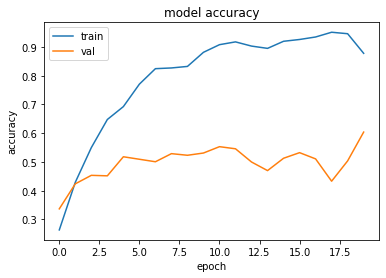

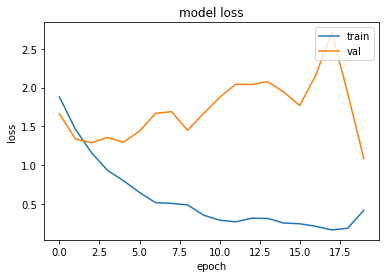

Best accuracy (on validation dataset): 60.39%
[[310   2   0  13   0   0   0   0]
 [ 52 338   3 141   9  27   4   0]
 [  0   0  66   0   0  15   0   2]
 [ 10 401   0 253   1   0   0   0]
 [ 32  86   0  55   2   0   0   0]
 [  1   1  56   0   0 121   0   0]
 [  0   1   0   0   0   0 179   0]
 [  0   0   0   0   0   1   0 123]]


<Figure size 432x288 with 0 Axes>

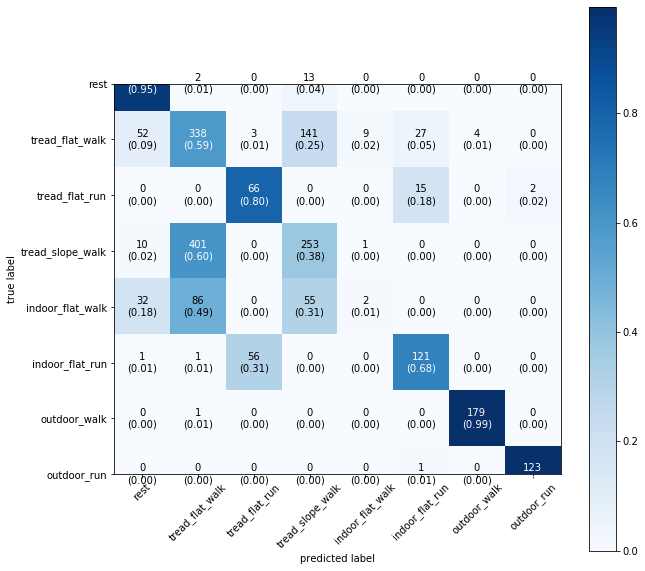

Classification Report:
                  precision    recall  f1-score   support

            rest     0.7654    0.9538    0.8493       325
 tread_flat_walk     0.4077    0.5889    0.4818       574
  tread_flat_run     0.5280    0.7952    0.6346        83
tread_slope_walk     0.5476    0.3805    0.4490       665
indoor_flat_walk     0.1667    0.0114    0.0214       175
 indoor_flat_run     0.7378    0.6760    0.7055       179
    outdoor_walk     0.9781    0.9944    0.9862       180
     outdoor_run     0.9840    0.9919    0.9880       124

        accuracy                         0.6039      2305
       macro avg     0.6394    0.6740    0.6395      2305
    weighted avg     0.5857    0.6039    0.5787      2305

Saved X_train to X_train_accX_LF_Window512_WaveletY_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window512_WaveletY_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window512_WaveletY_no_overlap_DifferentSubjectsInTrainT

4799/4799 [==============================] - 16s 3ms/step - loss: 0.7713 - acc: 0.7143 - val_loss: 1.4059 - val_acc: 0.4567

Epoch 00009: val_acc did not improve from 0.46021
Epoch 10/20
4799/4799 [==============================] - 16s 3ms/step - loss: 0.7088 - acc: 0.7447 - val_loss: 1.5442 - val_acc: 0.4775

Epoch 00010: val_acc improved from 0.46021 to 0.47751, saving model to model_v2.hdf5
Epoch 11/20
4799/4799 [==============================] - 16s 3ms/step - loss: 0.6578 - acc: 0.7672 - val_loss: 1.4874 - val_acc: 0.4524

Epoch 00011: val_acc did not improve from 0.47751
Epoch 12/20
4799/4799 [==============================] - 16s 3ms/step - loss: 0.5881 - acc: 0.7860 - val_loss: 1.3875 - val_acc: 0.4896

Epoch 00012: val_acc improved from 0.47751 to 0.48962, saving model to model_v2.hdf5
Epoch 13/20
4799/4799 [==============================] - 16s 3ms/step - loss: 0.5401 - acc: 0.8212 - val_loss: 1.7096 - val_acc: 0.4628

Epoch 00013: val_acc did not improve from 0.48962
Epoch 1

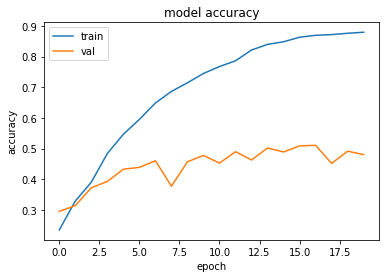

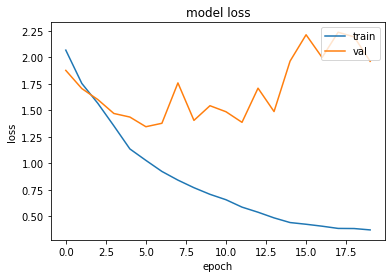

Best accuracy (on validation dataset): 48.01%
[[146   0   0  14   3   0   0   0]
 [ 10 105  14  82  54   5  17   0]
 [  0   0  37   0   0   4   1   0]
 [  2 120   0 126  84   1   0   0]
 [  2  10   0  44  28   2   2   0]
 [  0   0  73   0   0  15   2   0]
 [  0  38   0   0   0   0  51   1]
 [  0   0  16   0   0   0   0  47]]


<Figure size 432x288 with 0 Axes>

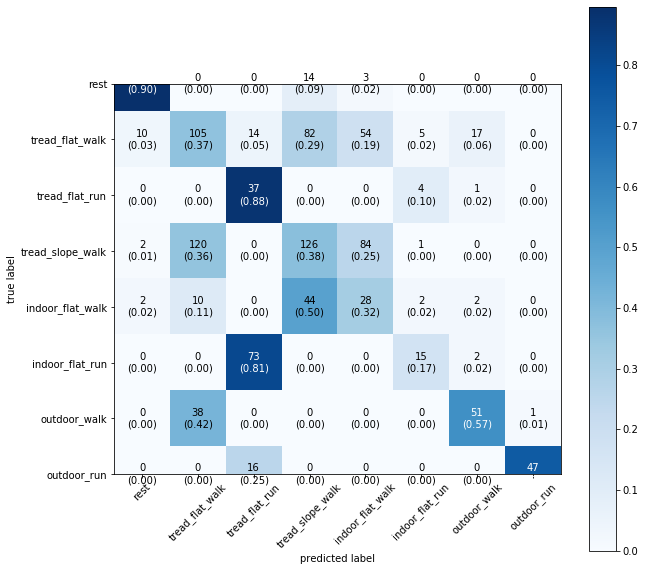

Classification Report:
                  precision    recall  f1-score   support

            rest     0.9125    0.8957    0.9040       163
 tread_flat_walk     0.3846    0.3659    0.3750       287
  tread_flat_run     0.2643    0.8810    0.4066        42
tread_slope_walk     0.4737    0.3784    0.4207       333
indoor_flat_walk     0.1657    0.3182    0.2179        88
 indoor_flat_run     0.5556    0.1667    0.2564        90
    outdoor_walk     0.6986    0.5667    0.6258        90
     outdoor_run     0.9792    0.7460    0.8468        63

        accuracy                         0.4801      1156
       macro avg     0.5543    0.5398    0.5067      1156
    weighted avg     0.5338    0.4801    0.4880      1156

Saved X_train to X_train_accX_LF_Window512_WaveletN_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window512_WaveletN_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window512_WaveletN_with_overlap_DifferentSubjectsIn

9564/9564 [==============================] - 32s 3ms/step - loss: 0.5927 - acc: 0.7938 - val_loss: 1.5340 - val_acc: 0.5432

Epoch 00009: val_acc did not improve from 0.57527
Epoch 10/20
9564/9564 [==============================] - 32s 3ms/step - loss: 0.5784 - acc: 0.7955 - val_loss: 1.6733 - val_acc: 0.4915

Epoch 00010: val_acc did not improve from 0.57527
Epoch 11/20
9564/9564 [==============================] - 32s 3ms/step - loss: 0.5532 - acc: 0.8020 - val_loss: 1.3715 - val_acc: 0.5614

Epoch 00011: val_acc did not improve from 0.57527
Epoch 12/20
9564/9564 [==============================] - 32s 3ms/step - loss: 0.4859 - acc: 0.8321 - val_loss: 1.5039 - val_acc: 0.5805

Epoch 00012: val_acc improved from 0.57527 to 0.58048, saving model to model_v3.hdf5
Epoch 13/20
9564/9564 [==============================] - 32s 3ms/step - loss: 0.4291 - acc: 0.8511 - val_loss: 1.5460 - val_acc: 0.5826

Epoch 00013: val_acc improved from 0.58048 to 0.58265, saving model to model_v3.hdf5
Epoch 1

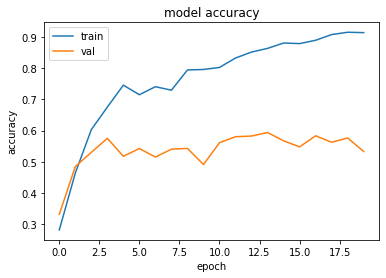

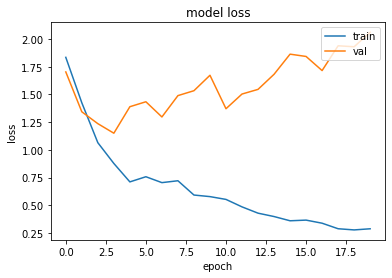

Best accuracy (on validation dataset): 53.32%
[[319   0   0   6   0   0   0   0]
 [ 51 116  29 274  82  11  11   0]
 [  0   2  79   1   0   1   0   0]
 [ 12  61   0 469 122   1   0   0]
 [  2  18   0 143  12   0   0   0]
 [  0   0 100   2  11  51  13   2]
 [  0  83   0   1  19   0  77   0]
 [  0   0   0   0   0  17   1 106]]


<Figure size 432x288 with 0 Axes>

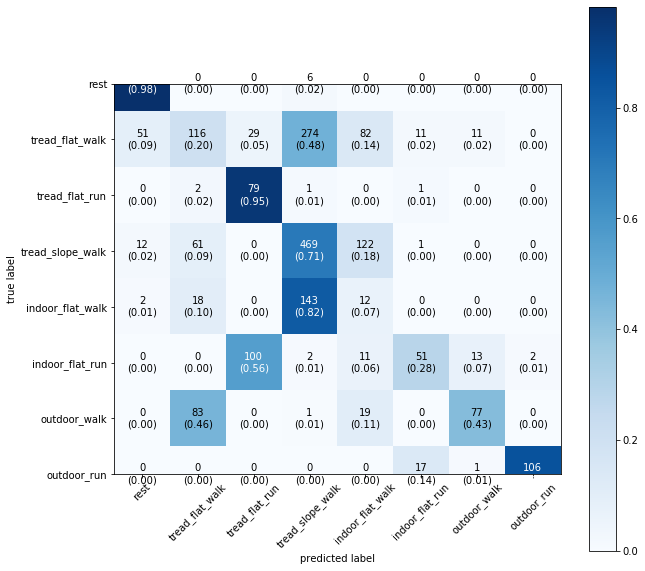

Classification Report:
                  precision    recall  f1-score   support

            rest     0.8307    0.9815    0.8999       325
 tread_flat_walk     0.4143    0.2021    0.2717       574
  tread_flat_run     0.3798    0.9518    0.5430        83
tread_slope_walk     0.5234    0.7053    0.6009       665
indoor_flat_walk     0.0488    0.0686    0.0570       175
 indoor_flat_run     0.6296    0.2849    0.3923       179
    outdoor_walk     0.7549    0.4278    0.5461       180
     outdoor_run     0.9815    0.8548    0.9138       124

        accuracy                         0.5332      2305
       macro avg     0.5704    0.5596    0.5281      2305
    weighted avg     0.5493    0.5332    0.5140      2305

Saved X_train to X_train_accX_LF_Window512_WaveletN_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window512_WaveletN_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window512_WaveletN_no_overlap_DifferentSubjectsInTrainT

4798/4798 [==============================] - 16s 3ms/step - loss: 0.7752 - acc: 0.7238 - val_loss: 1.5848 - val_acc: 0.3962

Epoch 00009: val_acc did not improve from 0.46972
Epoch 10/20
4798/4798 [==============================] - 16s 3ms/step - loss: 0.6851 - acc: 0.7630 - val_loss: 1.5986 - val_acc: 0.4221

Epoch 00010: val_acc did not improve from 0.46972
Epoch 11/20
4798/4798 [==============================] - 16s 3ms/step - loss: 0.5474 - acc: 0.8160 - val_loss: 1.6648 - val_acc: 0.4567

Epoch 00011: val_acc did not improve from 0.46972
Epoch 12/20
4798/4798 [==============================] - 16s 3ms/step - loss: 0.5153 - acc: 0.8314 - val_loss: 1.7103 - val_acc: 0.4472

Epoch 00012: val_acc did not improve from 0.46972
Epoch 13/20
4798/4798 [==============================] - 16s 3ms/step - loss: 0.4535 - acc: 0.8454 - val_loss: 1.8981 - val_acc: 0.4126

Epoch 00013: val_acc did not improve from 0.46972
Epoch 14/20
4798/4798 [==============================] - 16s 3ms/step - loss:

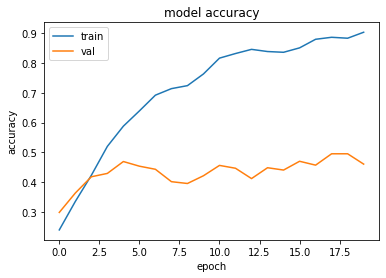

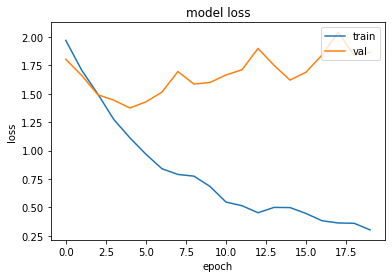

Best accuracy (on validation dataset): 46.11%
[[144   0   0  17   2   0   0   0]
 [  4  60   9 114  61  25  14   0]
 [  0   0  26   0   0  11   0   5]
 [  2 138   0 143  48   1   1   0]
 [  0  35   0  38  15   0   0   0]
 [  2   1  54   0   0  20  11   2]
 [  0  10   0   0   0   0  80   0]
 [  0   0   7   0   0   7   4  45]]


<Figure size 432x288 with 0 Axes>

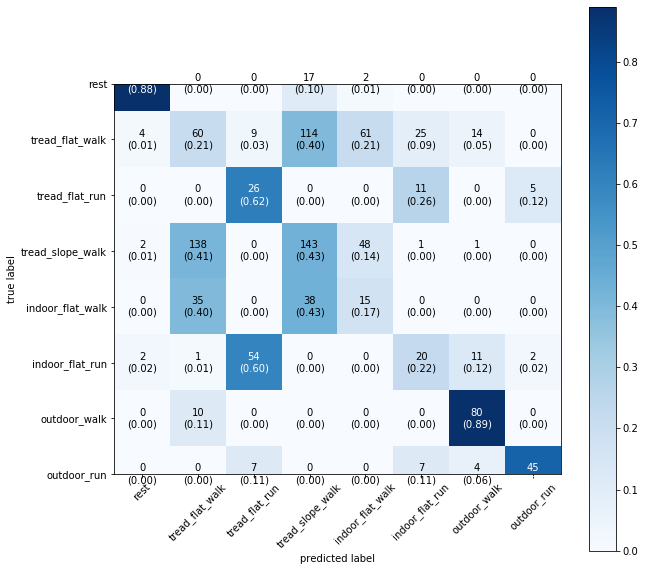

Classification Report:
                  precision    recall  f1-score   support

            rest     0.9474    0.8834    0.9143       163
 tread_flat_walk     0.2459    0.2091    0.2260       287
  tread_flat_run     0.2708    0.6190    0.3768        42
tread_slope_walk     0.4583    0.4294    0.4434       333
indoor_flat_walk     0.1190    0.1705    0.1402        88
 indoor_flat_run     0.3125    0.2222    0.2597        90
    outdoor_walk     0.7273    0.8889    0.8000        90
     outdoor_run     0.8654    0.7143    0.7826        63

        accuracy                         0.4611      1156
       macro avg     0.4933    0.5171    0.4929      1156
    weighted avg     0.4737    0.4611    0.4623      1156

Saved X_train to X_train_accX_LF_Window256_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window256_WaveletY_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window256_WaveletY_with_overlap_DifferentSubjectsIn

19222/19222 [==============================] - 33s 2ms/step - loss: 0.1472 - acc: 0.9567 - val_loss: 2.9236 - val_acc: 0.3638

Epoch 00009: val_acc did not improve from 0.42231
Epoch 10/20
19222/19222 [==============================] - 33s 2ms/step - loss: 0.1358 - acc: 0.9611 - val_loss: 2.6876 - val_acc: 0.3856

Epoch 00010: val_acc did not improve from 0.42231
Epoch 11/20
19222/19222 [==============================] - 33s 2ms/step - loss: 0.1321 - acc: 0.9623 - val_loss: 3.2040 - val_acc: 0.3837

Epoch 00011: val_acc did not improve from 0.42231
Epoch 12/20
19222/19222 [==============================] - 33s 2ms/step - loss: 0.1099 - acc: 0.9672 - val_loss: 3.5882 - val_acc: 0.3679

Epoch 00012: val_acc did not improve from 0.42231
Epoch 13/20
19222/19222 [==============================] - 32s 2ms/step - loss: 0.2641 - acc: 0.9207 - val_loss: 3.5838 - val_acc: 0.3735

Epoch 00013: val_acc did not improve from 0.42231
Epoch 14/20
19222/19222 [==============================] - 33s 2ms/

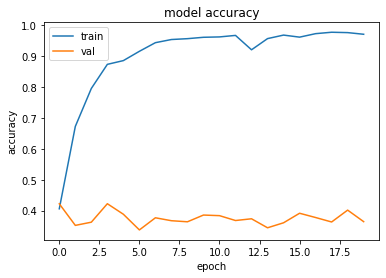

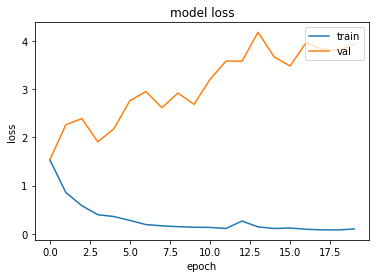

Best accuracy (on validation dataset): 36.43%
[[630   0   0   0  23   0   0   0]
 [ 77  24 638   1 396  14   1   0]
 [  0   0 166   0   0   3   0   0]
 [ 55  35 622   7 587  14  13   0]
 [  3  18 109   3 207   0  13   0]
 [  0   0 239   1   0 121   0   0]
 [  0  11   0   0   0   0 342  10]
 [  0   0   5   0   0  55   0 191]]


<Figure size 432x288 with 0 Axes>

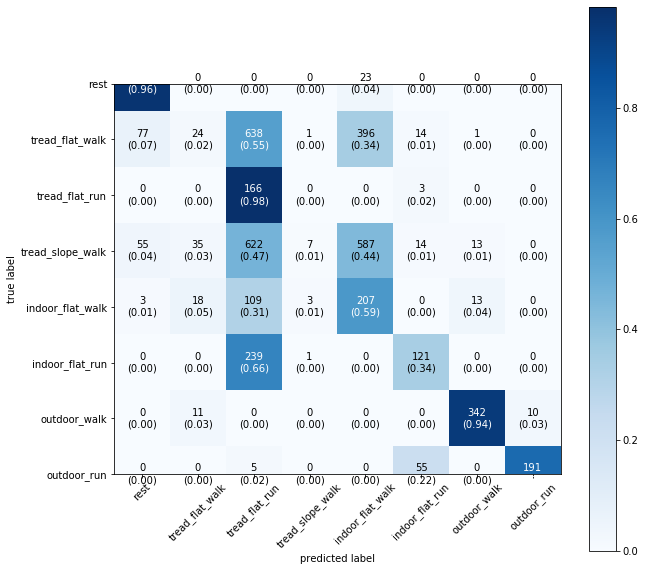

Classification Report:
                  precision    recall  f1-score   support

            rest     0.8235    0.9648    0.8886       653
 tread_flat_walk     0.2727    0.0209    0.0387      1151
  tread_flat_run     0.0933    0.9822    0.1704       169
tread_slope_walk     0.5833    0.0053    0.0104      1333
indoor_flat_walk     0.1707    0.5864    0.2644       353
 indoor_flat_run     0.5845    0.3352    0.4261       361
    outdoor_walk     0.9268    0.9421    0.9344       363
     outdoor_run     0.9502    0.7610    0.8451       251

        accuracy                         0.3643      4634
       macro avg     0.5506    0.5747    0.4473      4634
    weighted avg     0.5376    0.3643    0.3163      4634

Saved X_train to X_train_accX_LF_Window256_WaveletY_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window256_WaveletY_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window256_WaveletY_no_overlap_DifferentSubjectsInTrainT

9627/9627 [==============================] - 17s 2ms/step - loss: 0.3782 - acc: 0.8786 - val_loss: 1.7307 - val_acc: 0.5498

Epoch 00009: val_acc improved from 0.54416 to 0.54976, saving model to model_v6.hdf5
Epoch 10/20
9627/9627 [==============================] - 17s 2ms/step - loss: 0.4324 - acc: 0.8534 - val_loss: 1.5728 - val_acc: 0.5312

Epoch 00010: val_acc did not improve from 0.54976
Epoch 11/20
9627/9627 [==============================] - 17s 2ms/step - loss: 0.4682 - acc: 0.8392 - val_loss: 1.6831 - val_acc: 0.5704

Epoch 00011: val_acc improved from 0.54976 to 0.57044, saving model to model_v6.hdf5
Epoch 12/20
9627/9627 [==============================] - 16s 2ms/step - loss: 0.3549 - acc: 0.8830 - val_loss: 1.4096 - val_acc: 0.5756

Epoch 00012: val_acc improved from 0.57044 to 0.57561, saving model to model_v6.hdf5
Epoch 13/20
9627/9627 [==============================] - 17s 2ms/step - loss: 0.3624 - acc: 0.8849 - val_loss: 1.5869 - val_acc: 0.5661

Epoch 00013: val_acc d

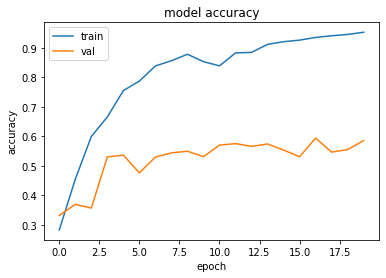

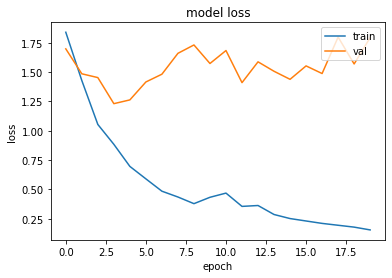

Best accuracy (on validation dataset): 58.60%
[[283   0   0  44   0   0   0   0]
 [ 49 105  20 239 157   0   6   0]
 [  0   5  62   2   4  12   0   0]
 [ 26  10   0 580  51   0   0   0]
 [  2   1   0 160  14   0   0   0]
 [  1   1 137   1   1  38   1   1]
 [  0   2   0   0   3   0 156  21]
 [  0   0   1   0   0   2   1 122]]


<Figure size 432x288 with 0 Axes>

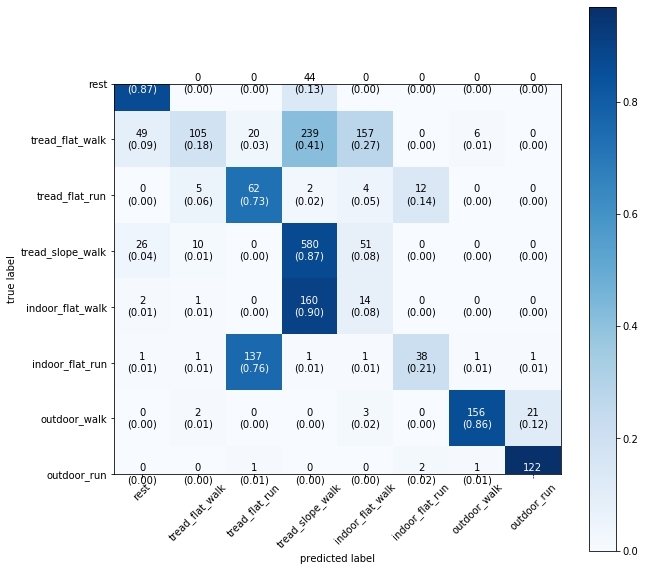

Classification Report:
                  precision    recall  f1-score   support

            rest     0.7839    0.8654    0.8227       327
 tread_flat_walk     0.8468    0.1823    0.3000       576
  tread_flat_run     0.2818    0.7294    0.4066        85
tread_slope_walk     0.5653    0.8696    0.6852       667
indoor_flat_walk     0.0609    0.0791    0.0688       177
 indoor_flat_run     0.7308    0.2099    0.3262       181
    outdoor_walk     0.9512    0.8571    0.9017       182
     outdoor_run     0.8472    0.9683    0.9037       126

        accuracy                         0.5860      2321
       macro avg     0.6335    0.5951    0.5519      2321
    weighted avg     0.6756    0.5860    0.5526      2321

Saved X_train to X_train_accX_LF_Window256_WaveletN_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window256_WaveletN_with_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window256_WaveletN_with_overlap_DifferentSubjectsIn

19221/19221 [==============================] - 35s 2ms/step - loss: 0.2214 - acc: 0.9360 - val_loss: 2.6451 - val_acc: 0.3912

Epoch 00009: val_acc did not improve from 0.48489
Epoch 10/20
19221/19221 [==============================] - 35s 2ms/step - loss: 0.1476 - acc: 0.9574 - val_loss: 2.7067 - val_acc: 0.4038

Epoch 00010: val_acc did not improve from 0.48489
Epoch 11/20
19221/19221 [==============================] - 34s 2ms/step - loss: 0.1247 - acc: 0.9648 - val_loss: 2.7214 - val_acc: 0.4117

Epoch 00011: val_acc did not improve from 0.48489
Epoch 12/20
19221/19221 [==============================] - 34s 2ms/step - loss: 0.1377 - acc: 0.9608 - val_loss: 2.5294 - val_acc: 0.4003

Epoch 00012: val_acc did not improve from 0.48489
Epoch 13/20
19221/19221 [==============================] - 34s 2ms/step - loss: 0.1430 - acc: 0.9618 - val_loss: 2.7352 - val_acc: 0.3925

Epoch 00013: val_acc did not improve from 0.48489
Epoch 14/20
19221/19221 [==============================] - 33s 2ms/

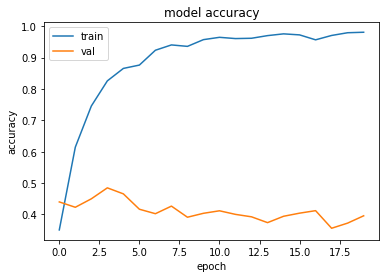

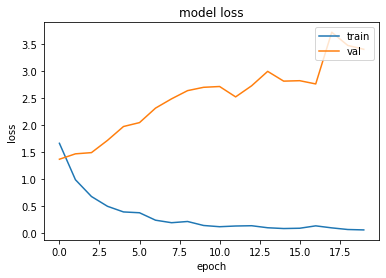

Best accuracy (on validation dataset): 39.58%
[[618   0   0  20  14   0   1   0]
 [272  52  87  63 537  98  40   2]
 [  0   0 117   0   1  48   0   3]
 [ 96 213   5 236 743  31   9   0]
 [  8  19   0  70 245  11   0   0]
 [  1   0 223   3   0 128   1   5]
 [  0 165   0   0   0   0 190   8]
 [  0   0   0   0   0   2   1 248]]


<Figure size 432x288 with 0 Axes>

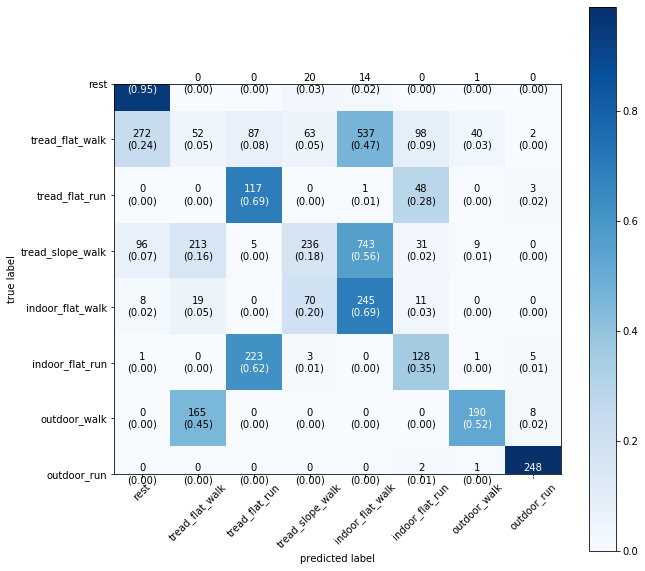

Classification Report:
                  precision    recall  f1-score   support

            rest     0.6211    0.9464    0.7500       653
 tread_flat_walk     0.1158    0.0452    0.0650      1151
  tread_flat_run     0.2708    0.6923    0.3894       169
tread_slope_walk     0.6020    0.1770    0.2736      1333
indoor_flat_walk     0.1591    0.6941    0.2588       353
 indoor_flat_run     0.4025    0.3546    0.3770       361
    outdoor_walk     0.7851    0.5234    0.6281       363
     outdoor_run     0.9323    0.9880    0.9594       251

        accuracy                         0.3958      4634
       macro avg     0.4861    0.5526    0.4627      4634
    weighted avg     0.4548    0.3958    0.3650      4634

Saved X_train to X_train_accX_LF_Window256_WaveletN_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_test to X_test_accX_LF_Window256_WaveletN_no_overlap_DifferentSubjectsInTrainTest.txt
Saved X_train to y_train_accX_LF_Window256_WaveletN_no_overlap_DifferentSubjectsInTrainT

9626/9626 [==============================] - 17s 2ms/step - loss: 0.4192 - acc: 0.8654 - val_loss: 2.0206 - val_acc: 0.4709

Epoch 00009: val_acc did not improve from 0.50108
Epoch 10/20
9626/9626 [==============================] - 17s 2ms/step - loss: 0.3778 - acc: 0.8800 - val_loss: 2.1309 - val_acc: 0.4248

Epoch 00010: val_acc did not improve from 0.50108
Epoch 11/20
9626/9626 [==============================] - 17s 2ms/step - loss: 0.3089 - acc: 0.9035 - val_loss: 2.1481 - val_acc: 0.4464

Epoch 00011: val_acc did not improve from 0.50108
Epoch 12/20
9626/9626 [==============================] - 17s 2ms/step - loss: 0.4183 - acc: 0.8628 - val_loss: 2.3139 - val_acc: 0.4196

Epoch 00012: val_acc did not improve from 0.50108
Epoch 13/20
9626/9626 [==============================] - 17s 2ms/step - loss: 0.3294 - acc: 0.8912 - val_loss: 2.7107 - val_acc: 0.4089

Epoch 00013: val_acc did not improve from 0.50108
Epoch 14/20
9626/9626 [==============================] - 17s 2ms/step - loss:

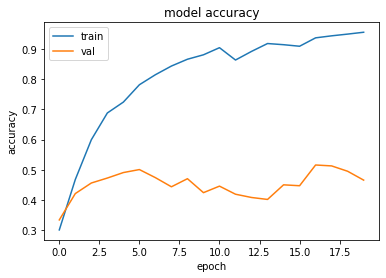

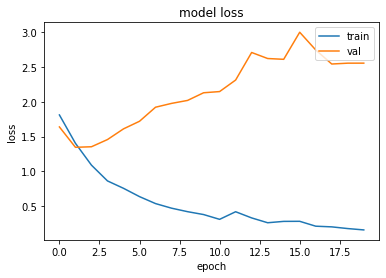

Best accuracy (on validation dataset): 46.62%
[[294   6   0  12  12   0   3   0]
 [ 52 222  12  16 104 147  22   1]
 [  0   0  61   0   2  19   0   3]
 [  9 312   1 149 171  25   0   0]
 [  0  72   2  11  37  43  12   0]
 [  0   0 112   1   0  67   0   1]
 [  0  42   0   0   0   0 139   1]
 [  0   1   1   0   0  11   0 113]]


<Figure size 432x288 with 0 Axes>

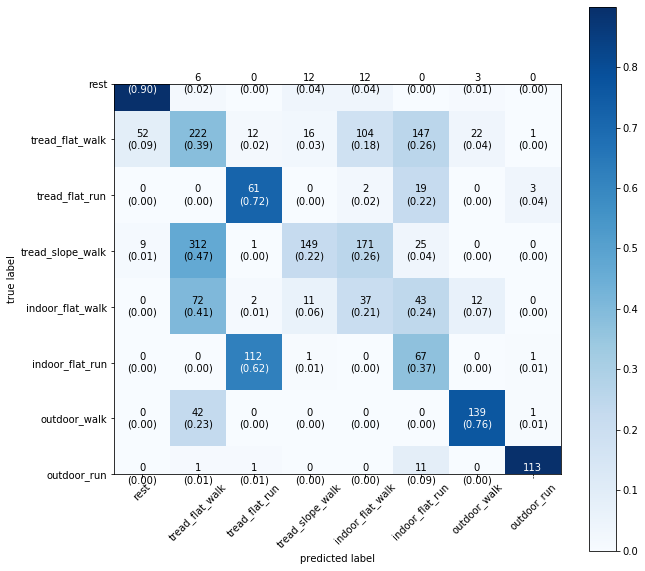

Classification Report:
                  precision    recall  f1-score   support

            rest     0.8282    0.8991    0.8622       327
 tread_flat_walk     0.3389    0.3854    0.3607       576
  tread_flat_run     0.3228    0.7176    0.4453        85
tread_slope_walk     0.7884    0.2234    0.3481       667
indoor_flat_walk     0.1135    0.2090    0.1471       177
 indoor_flat_run     0.2147    0.3702    0.2718       181
    outdoor_walk     0.7898    0.7637    0.7765       182
     outdoor_run     0.9496    0.8968    0.9224       126

        accuracy                         0.4662      2321
       macro avg     0.5432    0.5582    0.5168      2321
    weighted avg     0.5780    0.4662    0.4707      2321



In [60]:
# Permutation starts here:
axis_list = ['accX', 'accY', 'accZ']
pos_list = ['LF', 'RF', 'Waist', 'Wrist']

seed        = 29
np.random.seed(seed)

split_method_list = [
#     'TrainTestSplitWithinSubject',
#                     'Random',
                    'DifferentSubjectsInTrainTest'
                     ]
window_list = [512,
               256
               ]

wavelet_args_list = [
    {
        "type": "Y",
        "threshold": 2,
        "wavedec_options": {"wavelet": "db4", "level": 2},
        "waverec_options": {"wavelet": "db4"}
    },
    {"type": "N"}
]

window_args_list = [
#                     {"type": "by_peaks", "find_peaks_options": {"prominence": 30, "height": 20}}, 
                    {"type":"with_overlap", "overlap_perc":0.5}, 
                    {"type":"no_overlap"}
]

feature_list_list = [
    ['accX_LF', 'accY_LF'
      , 'accZ_LF', 'accX_RF', 'accY_RF', 'accZ_RF',
      'accX_Waist', 'accY_Waist', 'accZ_Waist', 'accX_Wrist', 'accY_Wrist', 'accZ_Wrist'
    ]
]

count = 0
for split_method in split_method_list:
    for window in window_list:
        for wavelet_args in wavelet_args_list:
            for window_args in window_args_list:
                for feature_list in feature_list_list:
                    count = count + 1
                    model_name = 'model_v' + str(count)
                    
                    feature_col = feature_list[0]
                    
                    for feature in feature_list:
                        prepare_single_feature_to_csv(feature, feature_col, model_name, split_method, window,
                                                      wavelet_args, window_args)

                    X_train, y_train, X_test, y_test = load_dataset(model_name, feature_list, window, wavelet_args, window_args,
                                                                    split_method)

                    print(X_train.shape)
                    print(y_train.shape)
                    print(X_test.shape)
                    print(y_test.shape)
                    print(X_train.shape[1])
                    print(X_train.shape[2])
                    print(y_train.shape[1])


                    train_predict_plot(X_train, y_train, X_test, y_test, model_name=model_name, verbose=1, epochs=20,
                                       batch_size=300)





In [36]:
X_train, y_train, X_test, y_test = load_dataset('model_v1', feature_list, window, wavelet_args, window_args,
                                                                    split_method)

In [38]:
X_train.shape

(15724, 512, 2)